In [1]:
# get the dataset from here: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

In [1]:
import os
import fiftyone as fo

dataset_path = '/home/saiteja/Desktop/pruning/data/cell_images'
DATASET_DIR = os.path.join(dataset_path,"cell_images/")

In [3]:
# # Create FiftyOne dataset
# dataset = fo.Dataset.from_dir(
#     DATASET_DIR,
#     fo.types.ImageClassificationDirectoryTree,
#     name="malaria-cell-images",
# )
# dataset.persistent = True

# print(dataset)

In [4]:
dataset = fo.load_dataset("malaria-cell-images")

In [5]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

/home/saiteja/anaconda3/envs/fastai_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


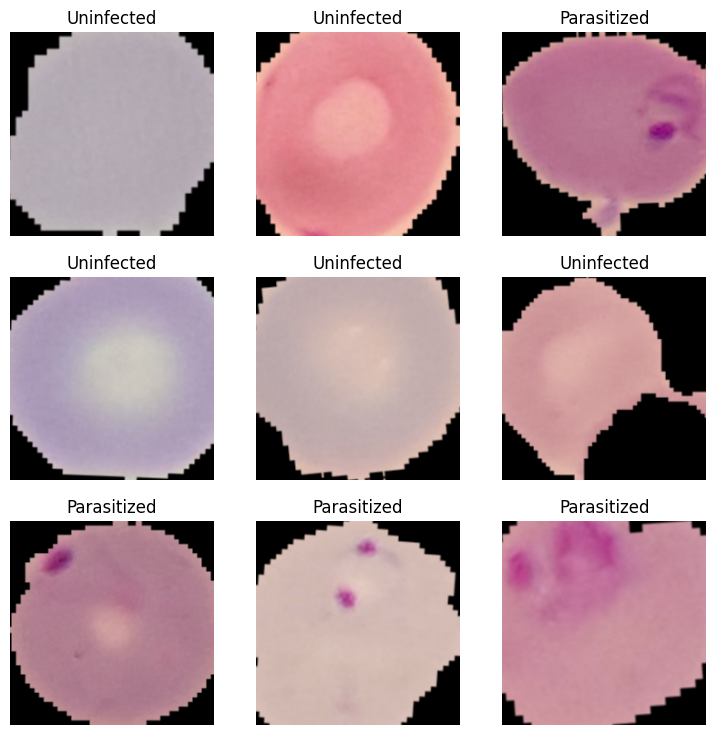

In [6]:
# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]
batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

In [7]:
# Load a pre-trained model
learner = cnn_learner(data, resnet18, metrics=[accuracy])
# learner.fine_tune()

/home/saiteja/anaconda3/envs/fastai_env/lib/python3.9/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/saiteja/anaconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saiteja/anaconda3/envs/fastai_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# learner.save("resnet18-malaria")

In [15]:
learner.load('resnet18-malaria')

In [16]:
from fiftyone import ViewField as F

def do_inference(learner, dl, dataset, classes, tag):
    # Perform inference
    preds, _ = learner.get_preds(ds_idx=dl.split_idx)
    preds = preds.numpy()

    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, scores in zip(pb(dl.items), preds):
            sample = dataset[str(filepath)]
            target = np.argmax(scores)
            sample.tags = [tag]
            sample["predictions"] = fo.Classification(
                label=classes[target],
                confidence=scores[target],
                logits=np.log(scores),
            )
            sample.save()

classes = list(data.vocab)

# Run inference on validation split
do_inference(learner, data.valid, dataset, classes, "validation")

 100% |███████████████| 5511/5511 [11.2s elapsed, 0s remaining, 471.0 samples/s]      


In [18]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=["Uninfected", "Parasitized"],
)

results.print_report()

              precision    recall  f1-score   support

  Uninfected       0.97      0.98      0.98     13780
 Parasitized       0.98      0.97      0.98     13780

    accuracy                           0.98     27560
   macro avg       0.98      0.98      0.98     27560
weighted avg       0.98      0.98      0.98     27560



# getting to know about the models now

In [19]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

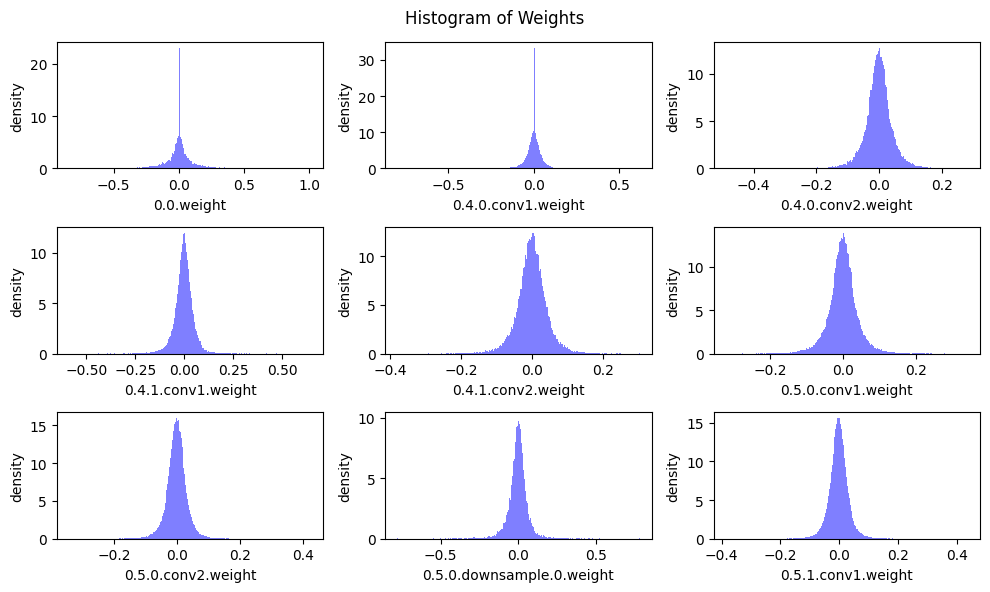

In [21]:
#Before we jump into pruning, let's see the distribution of weight values in the dense model.
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1 and plot_index<9:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(learner.model)

In [22]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [23]:

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [24]:
dataset.count_values("eval")

{'FN': 360, 'TP': 13420, 'TN': 13558, 'FP': 222}

In [25]:
from tqdm import tqdm

In [29]:
@torch.no_grad()
def sensitivity_scan(model, data, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) in model.named_parameters() if param.dim() > 1]
    
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        
        for sparsity in tqdm(sparsities, desc=f'Scanning {i_layer + 1}/{len(named_conv_weights)} layer - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            
            # Run inference on validation set
            do_inference(learner, data.valid, dataset, classes, "validation")
            acc = (lambda d: (d['TP'] + d['TN']) / sum(d.values()))(dataset.count_values("eval"))
            
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            
            # Restore the original weights
            param.copy_(param_clone)
            accuracy.append(acc)
        
        if verbose:
            print(f'\r    sparsity=[{",".join([f"{x:.2f}" for x in sparsities])}]: '
                  f'accuracy=[{", ".join([f"{x:.2f}%" for x in accuracy])}]', end='')
        
        accuracies.append(accuracy)

    return sparsities, accuracies


In [30]:
sparsities, accuracies = sensitivity_scan(
    learner.model,data , scan_step=0.1, scan_start=0.4, scan_end=1.0
    )

Scanning 1/22 layer - 0.0.weight:   0%|          | 0/6 [00:00<?, ?it/s]

 100% |███████████████| 5511/5511 [11.2s elapsed, 0s remaining, 497.0 samples/s]      


Scanning 1/22 layer - 0.0.weight:  17%|█▋        | 1/6 [00:21<01:46, 21.39s/it]

    sparsity=0.40: accuracy=0.98%

 100% |███████████████| 5511/5511 [11.8s elapsed, 0s remaining, 452.8 samples/s]      


Scanning 1/22 layer - 0.0.weight:  33%|███▎      | 2/6 [00:43<01:27, 21.77s/it]

    sparsity=0.50: accuracy=0.98%

  93% |█████████████\-| 5136/5511 [10.8s elapsed, 790.3ms remaining, 474.3 samples/s] 


Scanning 1/22 layer - 0.0.weight:  33%|███▎      | 2/6 [01:04<02:08, 32.23s/it]


KeyboardInterrupt: 